## Get the data

In [1]:
import pandas as pd
import os

def load_housing_data(housing_path):
    """
    load data from the given path
    input:
              path: path to where the data is stored
    output:
              df: pandas dataframe of the data
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    df = pd.read_csv(csv_path)
    return df

In [2]:
HOUSING_PATH = os.path.join("datasets", "housing")
housing = load_housing_data(HOUSING_PATH)

## Profile the data

In [3]:
from pandas_profiling import ProfileReport

profile = ProfileReport(housing)
profile.to_widgets()

Generate report structure: 100%|██████████████████| 1/1 [00:01<00:00,  1.98s/it]


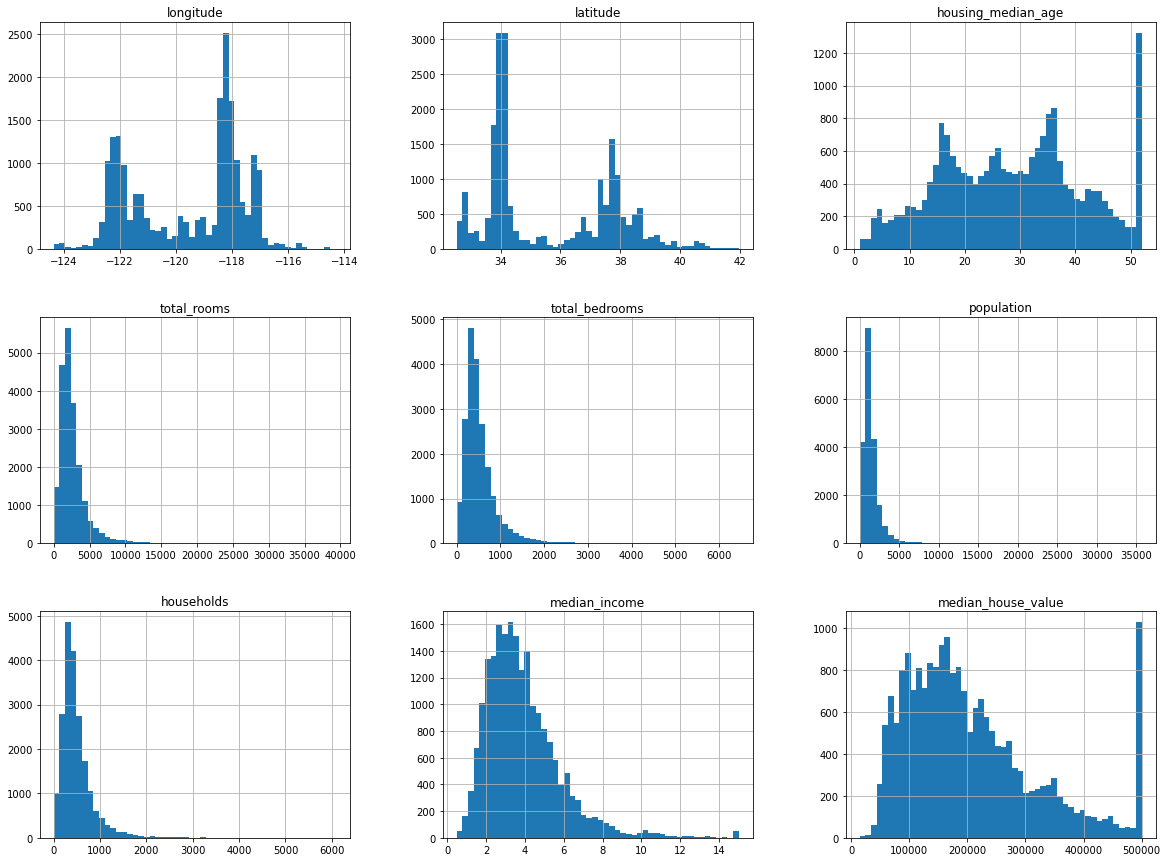

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

housing.hist(bins=50, figsize=(20,15))
plt.show()

Many of the histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

## Create a Test Set

In [5]:
import numpy as np

def split_train_test(data, test_ratio):
    """
    pick some instances of data randomly
    and set the aside
    input:
              data: data to split randomly into train and test sets
              test_ratio: percentage split of the data
    output:
              data.iloc[train_indices]: random train set
              data.iloc[test_indices]: random test set
    """
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [6]:
train_set, test_set = split_train_test(housing, 0.2)
print(f'Length of train set is {len(train_set)}')
print(f'Length of test set is {len(test_set)}')

Length of train set is 16512
Length of test set is 4128


Since the above function use random slices to split data, running it a couple of times will ensure the ML algo wil see all of the data.

To avoid this, compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. 

This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

In [7]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [8]:
# Since `housing` has no id column, the row index is used as the ID
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Row index as a unique ID means that any new data has to be appended at the end of the dataset, and no row gets deleted. That is a bit messy

Using the most stable features to build a unique ID can be a good option. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID

In [9]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [10]:
print(f'Length of train set is {len(train_set)}')
print(f'Length of test set is {len(test_set)}')

Length of train set is 16322
Length of test set is 4318


### alternatively
use scikit-learn's `train_test_split` which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features. 
1. First there is a random_state parameter that allows you to set the random generator seed (generates shuffled indices), and 
2. second you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels): 

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

the median income is a very important attribute to predict median housing prices.
You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute.

looking at the median income histogram more closely, most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. 

It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough.

The following code uses the `pd.cut()` function to create an income category attribute with 5 categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [14]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
    labels = [1, 2, 3, 4, 5]
)

<AxesSubplot:>

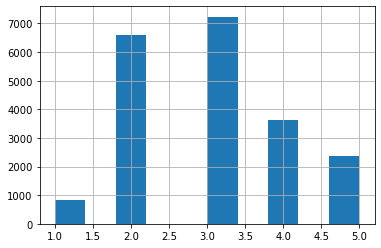

In [15]:
housing["income_cat"].hist()

Now stratified sampling based on the income category
using scikit-learn's `StratifiedShuffleSplit` class

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    stratified_train_set = housing.loc[train_idx]
    stratified_test_set = housing.loc[test_idx]

Now you should remove the income_cat attribute so the data is back to its original state:

In [19]:
for set_ in (stratified_train_set, stratified_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the data

First, put the test set aside and you are only exploring the train‐ ing set.
If the training set is very large, sample an exploration set, to make manipulations easy and fast.

In [20]:
# create a copy of the housing data
housing = stratified_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

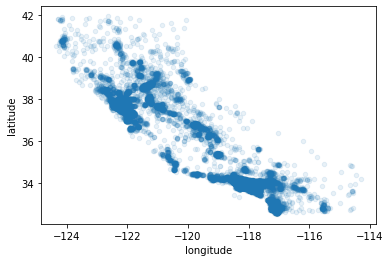

In [22]:
# visualize geographic data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

Plot the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the price (option c). Use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

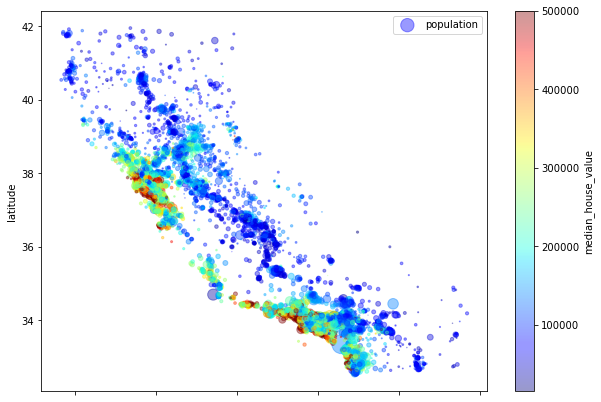

In [23]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=housing["population"]/100,
    label="population",
    figsize=(10,7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True
)

plt.legend()

In [24]:
# looking for correlations (done by profiler already)
corr_matrix = housing.corr()

In [25]:
# how much each attribute correlates to median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Another way to check for correlation between attributes is to use Pandas’ scatter_matrix function, which plots every numerical attribute against every other numerical attribute.

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

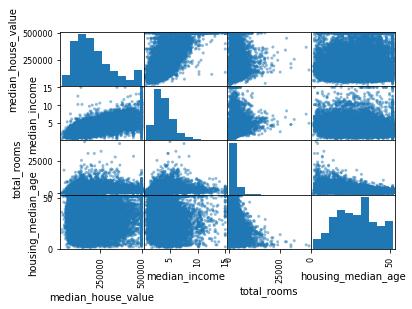

In [26]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes])

The most promising attribute to predict the median house value is the median income,

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

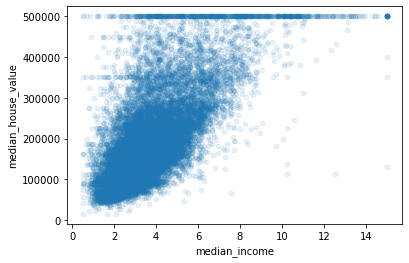

In [27]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed.

## Experimenting with Attribute Combinations

For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

In [28]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [29]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

## Prepare the Data for ML Algorithms

let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values 

In [30]:
# drop() creates a copy of the data and does not affect the original
housing = stratified_train_set.drop("median_house_value", axis=1)
housing_labels = stratified_train_set["median_house_value"].copy()

create `SimpleImputer` instance,specify replacement for each attributes missing value with the median of that sttribute

In [32]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# create a copy of the data with only numerical attributes
housing_num = housing.drop("ocean_proximity", axis=1)
# fit the imputer to the training data
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has simply computed the median of each attribute and stored the result in its `statistics_` instance variable. Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [33]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [34]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

In [35]:
X = imputer.transform(housing_num) #gives a plain NumPy array containing the transformed features

# putting it into a pandas df
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling Text and Categorical Attributes

In [36]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


convert these categories from text to numbers using Scikit-Learn’s `OrdinalEncoder` class19:

In [37]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [38]:
# get list of categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1).

To fix this issue, use one-hot encoding:

In [39]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes.

You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inher‐ itance), all you need is to create a class and implement three methods: `fit()` (returning self), `transform()`, and `fit_transform()`.

You can get the last one for free by simply adding TransformerMixin as a base class. Also, if you add BaseEstimator as a base class (and avoid *args and ****kargs** in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for auto hyperparameter tuning.

In [40]:
# transformer class that adds the combined attributes from earlier
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): #no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix] 
        population_per_household = X[:, population_ix] / X[:, households_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the hous‐ ing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: *min-max scaling* (aka normalization) and *standardization*.

### Transformation Pipelines

there are many data transformation steps that need to be executed in the right order. Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns separately.It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column:

In [42]:
# apply all transformations to the housing data
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

Here is how this works: 
1. first we import the ColumnTransformer class, 
2. next we get the list of numerical column names and the list of categorical column names, 
3. and we construct a ColumnTransformer. The constructor requires a list of tuples, where each tuple contains a name, a transformer and a list of names (or indices) of columns that the transformer should be applied to. 


In this example, we specify that the numerical columns should be transformed using the num_pipeline that we defined earlier, and the categorical columns should be transformed using a OneHotEncoder. Finally, we apply this ColumnTransformer to the housing data: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

## Select and Train a Model

In [43]:
# linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [44]:
# try it on a few instances of the data
data = housing.iloc[:5]
labels = housing_labels.iloc[:5]
data_prepared = full_pipeline.transform(data)

print("Predictions: ", lin_reg.predict(data_prepared))
print("Labels: ", list(labels))

Predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


measure this regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error function:

In [45]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_mse = np.sqrt(lin_mse)
print(f'RMSE: {lin_mse}')

RMSE: 68627.87390018745


clearly not a great score: most districts’ median_housing_values range between $120,000 and $265,000, so a typical predic‐ tion error of $68,628 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

In [46]:
# try a Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [47]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_mse = np.sqrt(tree_mse)
print(f'Tree Regressor RMSE: {tree_mse}')

Tree Regressor RMSE: 0.0


this model returns a zero error which might imply overfitting.

A great way to evaluate a Decision Tree Model is to use Scikit-Learn’s K-fold cross-validation feature. The follow‐ ing code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array con‐ taining the 10 evaluation scores:

In [48]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a neg‐ ative value), which is why the preceding code computes `-scores` before calculating the square root.

In [49]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Std: {scores.std()}')

In [50]:
display_scores(tree_rmse_scores)

Scores: [71746.32813779 70433.78353199 69438.6828914  72015.3602999
 70542.63731008 76776.82870805 70815.35128086 74471.22516942
 69538.84454451 71500.44405357]
Mean: 71727.94859275628
Std: 2170.185067860695


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to per‐ form worse than the Linear Regression model! 

Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). 

The Decision Tree has a score of approximately 71,728, generally ±2,170. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

In [51]:
# compute the same scores for the Linear Regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71774.15825125 64114.99166359 67771.17124356 68627.7242824
 66848.58938823 72527.24321966 74023.75820358 68800.50640085
 66443.28836884 70147.43163952]
Mean: 69107.88626614638
Std: 2886.049299226037


In [52]:
# try the Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [53]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(f'Forest RMSE: {forest_rmse}')

Forest RMSE: 18767.753878788568


In [55]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51720.49079109 49194.35945331 46581.5432496  51896.78703448
 47107.96390708 51561.82535402 52344.99130522 50172.03487372
 48392.09566257 53551.87496251]
Mean: 50252.39665935897
Std: 2231.337617905101


Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

However, before you dive much deeper in Random Forests, you should try out many other models from various categories of Machine Learning algorithms (several Sup‐ port Vector Machines with different kernels, possibly a neural network, etc.), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

You can easily save Scikit-Learn models by using Python’s pickle module, or using sklearn.externals.joblib, which is more efficient at serializing large NumPy arrays:

```
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")
```

## Fine-Tune Your Model

One way to do that would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

### Grid Search

Instead you should get Scikit-Learn’s GridSearchCV to search for you. All you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. 

For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap': [False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(
    forest_reg, param_grid, cv=5,
    scoring = 'neg_mean_squared_error',
    return_train_score=True
)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [57]:
# get the best estimator
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [58]:
# evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64755.47098195708 {'max_features': 2, 'n_estimators': 3}
55298.27853323101 {'max_features': 2, 'n_estimators': 10}
52635.23798618079 {'max_features': 2, 'n_estimators': 30}
60163.31481237995 {'max_features': 4, 'n_estimators': 3}
52913.50045135987 {'max_features': 4, 'n_estimators': 10}
50230.36783918309 {'max_features': 4, 'n_estimators': 30}
59586.67197517338 {'max_features': 6, 'n_estimators': 3}
52202.26164196577 {'max_features': 6, 'n_estimators': 10}
49990.14945715423 {'max_features': 6, 'n_estimators': 30}
59087.2725622182 {'max_features': 8, 'n_estimators': 3}
52176.92216573024 {'max_features': 8, 'n_estimators': 10}
50049.54848187738 {'max_features': 8, 'n_estimators': 30}
61651.49562346189 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54004.07418992868 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59531.90354407965 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52356.70351762415 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

### Randomized Search

This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
1. If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few val‐ ues per hyperparameter with the grid search approach).
2. You have more control over the computing budget you want to allocate to hyper‐ parameter search, simply by setting the number of iterations.

### Ensemble Methods

Another way to fine-tune your system is to try to combine the models that perform best. The group (or “ensemble”) will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different types of errors.

You will often gain good insights on the problem by inspecting the best models. For example, the `RandomForestRegressor` can indicate the relative importance of each attribute for making accurate predictions:

In [59]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.38512378e-02, 7.09880455e-02, 3.84376343e-02, 1.78580507e-02,
       1.52241424e-02, 1.67206251e-02, 1.54619940e-02, 3.45351020e-01,
       5.50559253e-02, 1.05233945e-01, 6.43372822e-02, 1.59344286e-02,
       1.44550813e-01, 1.40711487e-04, 4.63109181e-03, 6.22305274e-03])

In [60]:
# display the importance scores next to their corresponding feature names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [61]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3453510204074926, 'median_income'),
 (0.144550812979423, 'INLAND'),
 (0.10523394465802596, 'pop_per_hhold'),
 (0.08385123776126571, 'longitude'),
 (0.07098804553670729, 'latitude'),
 (0.06433728223240272, 'bedrooms_per_room'),
 (0.055055925259389425, 'rooms_per_hhold'),
 (0.03843763427708142, 'housing_median_age'),
 (0.017858050716281663, 'total_rooms'),
 (0.01672062509247572, 'population'),
 (0.015934428567829853, '<1H OCEAN'),
 (0.015461994043091305, 'households'),
 (0.015224142432291875, 'total_bedrooms'),
 (0.00622305273511765, 'NEAR OCEAN'),
 (0.0046310918140063054, 'NEAR BAY'),
 (0.00014071148711755423, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).

## Evaluate Your System on the Test Set

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; 

just get the predictors and the labels from your test set, run your `full_pipeline` to transform the data (call `transform()`, not `fit_transform()`, you do not want to fit the test set!), and evaluate the final model on the test set:

In [63]:
final_model = grid_search.best_estimator_

X_test = stratified_test_set.drop("median_house_value", axis=1)
y_test = stratified_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f'Final RMSE: {final_rmse}')

Final RMSE: 47482.8591326457


In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just 0.1% better than the model currently in production? You might want to have an idea of how precise this estimate is. For this, you can compute a 95% confidence interval for the generalization error using `scipy.stats.t.interval()`:

In [64]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc = squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45433.16083141, 49447.66647364])